code ini menggunakan dataset mama, menggunakan metode penelitian LSTM

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [59]:
# 1. Persiapan Data
df = pd.read_csv('backtest-template-v2 (8).csv', sep=';')
df['Tanggal Entry'] = pd.to_datetime(df['Tanggal Entry'], format='%d-%b-%Y')
df = df.sort_values('Tanggal Entry')

In [60]:
# Menggunakan harga 'Entry' sebagai target
prices = df['Entry'].values.reshape(-1, 1)


In [61]:
# 2. Pra-pemrosesan Data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [62]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [63]:
sequence_length = 10  # Anda bisa menyesuaikan ini
X, y = create_sequences(prices_scaled, sequence_length)

In [64]:
# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# 3. Membuat Model LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [67]:
# 4. Melatih Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.3851 - val_loss: 0.3633
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2803 - val_loss: 0.2431
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1943 - val_loss: 0.0803
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0491 - val_loss: 0.0221
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0409 - val_loss: 0.0077
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0242 - val_loss: 0.0186
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0251 - val_loss: 0.0188
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0212 - val_loss: 0.0071
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0186 - val_loss: 0.0077
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0181 - val_loss: 0.0055
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0128 - val_loss: 0.0074
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0153 - val_loss: 0.0052


In [68]:
# 5. Evaluasi Model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Train Loss: 0.006557056680321693
Test Loss: 0.007224352099001408


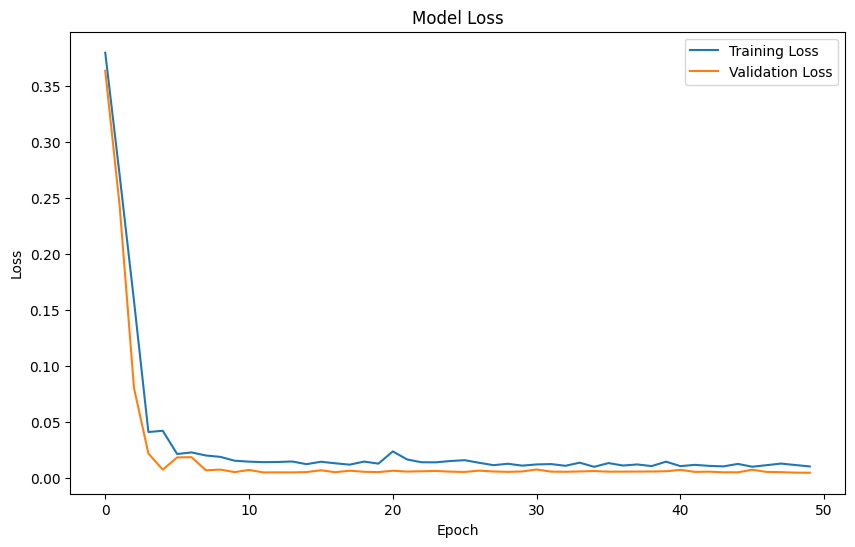

In [69]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
# 6. Membuat Prediksi
def predict_next_day(model, last_sequence):
    next_day_pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    return scaler.inverse_transform(next_day_pred)[0, 0]

last_sequence = prices_scaled[-sequence_length:]
next_day_price = predict_next_day(model, last_sequence)
print(f'Predicted price for next day: {next_day_price:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
Predicted price for next day: 1.2681


In [71]:
# Prediksi untuk beberapa hari ke depan
num_days = 7
predictions = []
current_sequence = last_sequence.reshape(1, sequence_length, 1)

for _ in range(num_days):
    next_pred = model.predict(current_sequence)
    predictions.append(next_pred[0, 0])
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_pred

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


C:\Users\HP\AppData\Local\Temp\ipykernel_13608\3261776266.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[0, -1, 0] = next_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [72]:
print("\nPredictions for the next 7 days:")
for i, pred in enumerate(predictions):
    print(f"Day {i+1}: {pred[0]:.4f}")


Predictions for the next 7 days:
Day 1: 1.2681
Day 2: 1.2681
Day 3: 1.2685
Day 4: 1.2683
Day 5: 1.2682
Day 6: 1.2671
Day 7: 1.2666


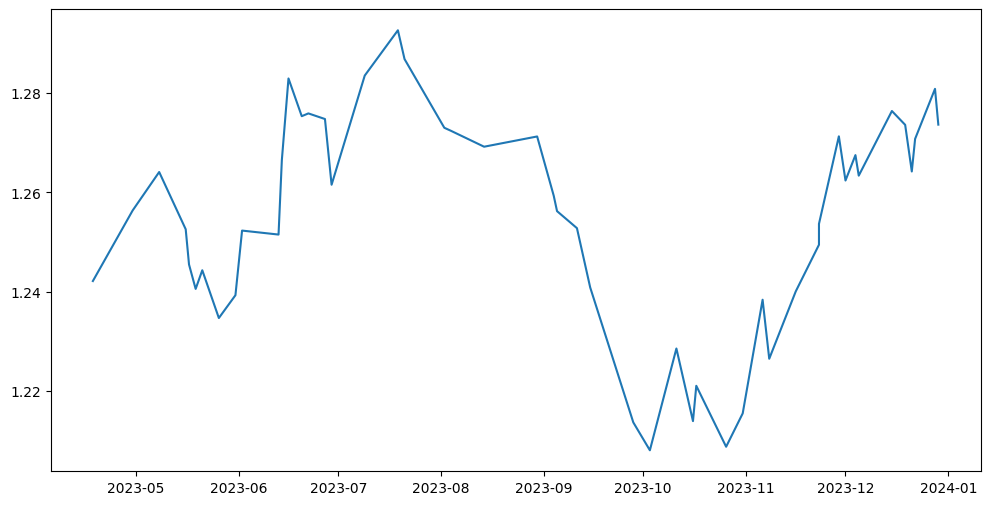

In [73]:
# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal Entry'][-50:], prices[-50:], label='Actual Prices')

In [74]:
# Membuat tanggal untuk prediksi
last_date = df['Tanggal Entry'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days)

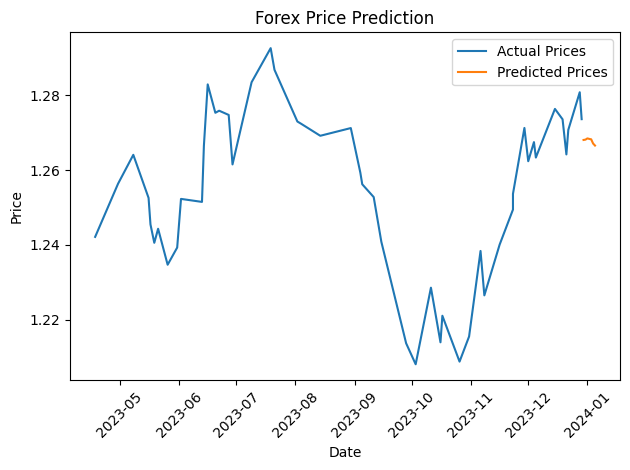

In [75]:
# Plot data aktual dan prediksi
plt.plot(df['Tanggal Entry'][-50:], prices[-50:], label='Actual Prices')
plt.plot(future_dates, predictions, label='Predicted Prices')

plt.title('Forex Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()